<a href="https://colab.research.google.com/github/kghilothia06/Time-Series-Forecasting/blob/main/Univariate_encoder_decoder_LSTM_20_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# univariate multi-step encoder-decoder lstm for sales prediction

In [1]:
# import libraries
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_excel, DataFrame
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed


In [2]:
# split a univariate dataset into train/test sets
def split_dataset(data,partition):
  # split into partition
  train = data[:-partition] 
  test = data[-partition:]
  # restructure into windows 
  train = array(split(train, len(train)/partition))
  test = array(split(test, len(test)/partition))
  return train, test

In [3]:
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores


In [4]:
# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))


In [5]:
# convert history into inputs and outputs
def to_supervised(train, n_input, n_out):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end < len(data):
			x_input = data[in_start:in_end, 0]
			x_input = x_input.reshape((len(x_input), 1))
			X.append(x_input)
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return array(X), array(y)


In [6]:
# train the model
def build_model(train, n_input, n_out):
	# prepare data
	train_x, train_y = to_supervised(train, n_input, n_out)
	# define parameters
	verbose, epochs, batch_size = 0, 20, 12
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# reshape output into [samples, timesteps, features]
	train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
	# define model
	model = Sequential()
	model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
	model.add(RepeatVector(n_outputs))
	model.add(LSTM(200, activation='relu', return_sequences=True))
	model.add(TimeDistributed(Dense(100, activation='relu')))
	model.add(TimeDistributed(Dense(1)))
	model.compile(loss='mse', optimizer='adam')
	# fit network
	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
	return model


In [7]:
# make a forecast
def forecast(model, history, n_input):
	# flatten data
	data = array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	# retrieve last observations for input data
	input_x = data[-n_input:, 0]
	# reshape into [1, n_input, 1]
	input_x = input_x.reshape((1, len(input_x), 1))
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)
	# we only want the vector forecast
	yhat = yhat[0]
	return yhat


In [8]:
# evaluate a single model
def evaluate_model(train, test, n_input, n_out):
	# fit model
	model = build_model(train, n_input, n_out)
	# history is a list of weekly data
	history = [x for x in train]
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = forecast(model, history, n_input)
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	# evaluate predictions days for each week
	predictions = array(predictions)
	score, scores = evaluate_forecasts(test[:, :, 0], predictions)
	return score, scores


Load Quarterly data

> Here, all the 4 quarters are predicted based on previous 4 quarters

lstm: [144227.688] 16513.8, 16859.2, 206327.6, 200196.1


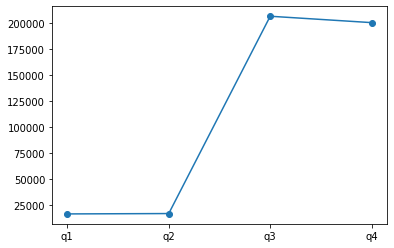

In [9]:
# load the new file
dataset = read_excel('/content/Sales-quarterly.xlsx', header=0, index_col=0)
dataset = DataFrame(dataset['Sales'])
# split into train and test
partition = 4
train, test = split_dataset(dataset.values,partition)
# evaluate model and get scores
n_input = 4
n_out = 4
score, scores = evaluate_model(train, test, n_input, n_out)
# summarize scores
summarize_scores('lstm', score, scores)
# plot scores
quarter_list = ['q1', 'q2', 'q3', 'q4']
pyplot.plot(quarter_list, scores, marker='o', label='lstm')
pyplot.show()

Load Monthly data

> Here, all the 12 months are predicted based on previous 12 months

lstm: [282124.835] 23422.3, 60196.7, 6835.7, 129488.8, 179324.5, 85461.2, 319408.9, 306236.2, 307443.6, 504341.8, 555820.1, 202645.3


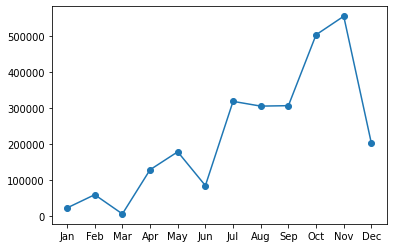

In [10]:
# load the new file
dataset = read_excel('/content/Sales-monthly.xlsx', header=0, index_col=0)
#dataset = DataFrame(dataset['Sales'])
# split into train and test
partition = 12
train, test = split_dataset(dataset.values,partition)
# evaluate model and get scores
n_input = 12
n_out = 12
score, scores = evaluate_model(train, test, n_input, n_out)
# summarize scores
summarize_scores('lstm', score, scores)
# plot scores
month_list = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
pyplot.plot(month_list, scores, marker='o', label='lstm')
pyplot.show()